# Second Order Infinite Gain Multiple Feedback BP Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

| Band number | C [$\mu F$] | $f_L$ [$Hz$] | $f_H$ [$Hz$] |
| ----------- | ----------- | ------------ | ------------ |
| 01          | 0.91        | 65           | 105          |
| 02          | 1.3         | 90           | 150          |
| 03          | 1.8         | 125          | 200          |
| 04          | 2.4         | 175          | 285          |
| 05          | 3.3         | 255          | 400          |
| 06          | 4.7         | 345          | 555          |
| 07          | 6.8         | 465          | 755          |
| 08          | 9.1         | 635          | 1050         |
| 09          | 13          | 920          | 1455         |
| 10          | 18          | 1220         | 1960         |
| 11          | 24          | 1765         | 2880         |
| 12          | 33          | 2500         | 4075         |
| 13          | 47          | 3515         | 5605         |
| 14          | 68          | 4640         | 7550         |
| 15          | 91          | 6375         | 10375        |
| 16          | 130         | 9200         | 15000        |

In [68]:
r1 = 33000
r2 = 2000
r3 = 200000
r4 = 20000
r5 = 1200
r6 = 120000

def H(s: complex, c: float) -> complex:
    """Evaluates transfer function of the 2nd order MFIG BP filter.

    The filter frequency only depends on the capacitor used in the
    feedback path.

    Parameters
    ----------
    s
        Complex frequency.
    c
        Capacitor value in Farad.

    Returns
    -------
    complex
        The transfer function value.

    """
    numerator_1 = -s / (r1 * c + 0j)
    denominator_1 = s**2 + s * 2 / (r3 * c + 0j) + (1 / r1 + 1 / r2 + 0j) / (r3 * c**2 + 0j)
    numerator_2 = -s / (r4 * c + 0j)
    denominator_2 = s**2 + s * 2 / (r6 * c + 0j) + (1 / r4 + 1 / r5 + 0j) / (r6 * c**2 + 0j)
    return numerator_1 * numerator_2 / (denominator_1 * denominator_2)

Text(0, 0.5, '$\\|H(\\omega)\\|$ [$dB$]')

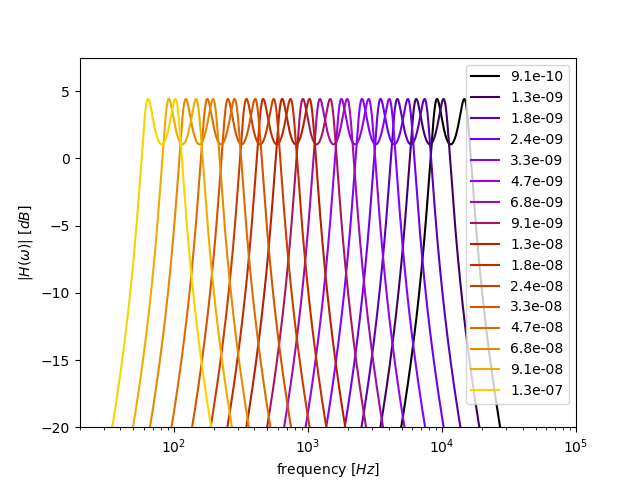

In [93]:
%matplotlib widget

caps = [
    0.91e-9,
    1.3e-9,
    1.8e-9,
    2.4e-9,
    3.3e-9,
    4.7e-9,
    6.8e-9,
    9.1e-9,
    13e-9,
    18e-9,
    24e-9,
    33e-9,
    47e-9,
    68e-9,
    91e-9,
    130e-9,
]

# Generate some complex frequiencies.
s = 1j * np.logspace(0, 6, 10000)
omega = s.imag / (2 * np.pi)

# Plot all the transfer functions.
fig, ax = plt.subplots()

for i, cap, in enumerate(caps):
    color = plt.cm.gnuplot(i / len(caps))
    ax.semilogx(omega, 20 * np.log10(abs(H(s, cap))), c=color, label=f"{cap}")

plt.xlim(20, 100000)
plt.ylim(-20, 7.5)
plt.legend(caps)
plt.xlabel("frequency [$Hz$]")
plt.ylabel("$\|H(\omega)\|$ [$dB$]")

# Speech Frequency Analysis

In [24]:
from scipy.io.wavfile import read
from scipy.signal import hilbert, butter, lfilter
from numpy.fft import fft, fftfreq

In [63]:
def butter_bp_filter(signal: np.ndarray, f_low: float, f_high: float, f_sample: float, order: int) -> np.ndarray:
    """Applies the specified butterworth bandpass filter to some signal.

    Parameters
    ----------
    signal
        The signal to be filtered.
    f_low
        Lower cutoff frequency.
    f_high
        Upper cutoff frequency.
    f_sample
        Sample frequency.
    order
        Filter order.

    Returns
    -------
    np.ndarray
        The filtered signal.

    """
    f_nyquist = f_sample / 2
    omega_low = f_low / f_nyquist
    omega_high = f_high / f_nyquist
    numerator, denominator = butter(order, [omega_low, omega_high], btype="band")
    filtered = lfilter(numerator, denominator, signal)
    return filtered

Text(0, 0.5, 'FFT(signal) [arbitrary unit]')

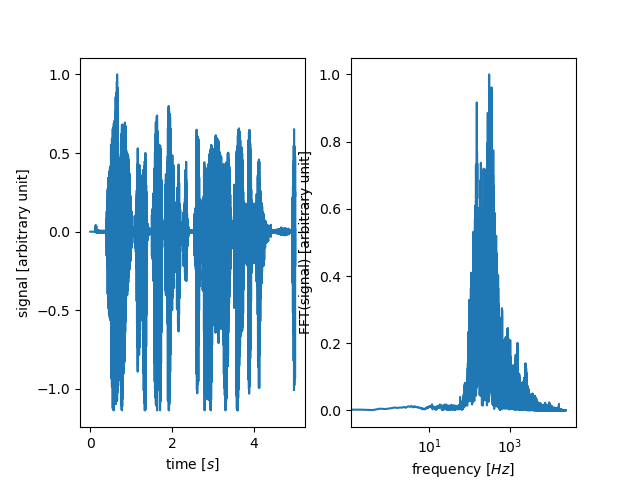

In [60]:
%matplotlib widget

# Load audio.
f_sample, audio = read("audio/test.wav")

# Number of samples.
n = audio.size

# Calculate the time and frequency x axis values.
t = np.linspace(0, n / f_sample, n)
f = fftfreq(n, 1 / f_sample)

audio_fft = fft(audio)

# Plot signal and FFT.
fig, axs = plt.subplots(1, 2)

axs[0].plot(t, audio / max(audio))
axs[0].set_xlabel("time [$s$]")
axs[0].set_ylabel("signal [arbitrary unit]")

axs[1].semilogx(f[:n//2], abs(audio_fft[:n//2]) / max(abs(audio_fft[:n//2])))
axs[1].set_xlabel("frequency [$Hz$]")
axs[1].set_ylabel("FFT(signal) [arbitrary unit]")

Text(0, 0.5, 'FFT(signal) [arbitrary unit]')

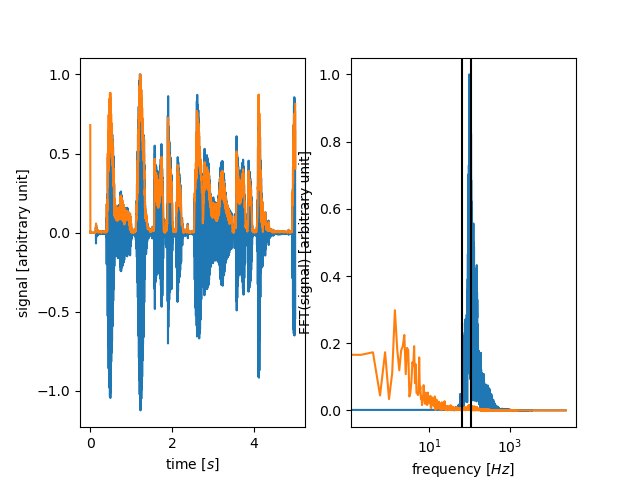

In [67]:
%matplotlib widget

# Apply a filter.
filtered = butter_bp_filter(audio, f_low=65, f_high=105, f_sample=f_sample, order=2)
filtered_fft = fft(filtered)

# Compute the signal envelope.
analytic = hilbert(filtered)
amplitude_env = np.abs(analytic)
amplitude_env_fft = fft(amplitude_env)

# Plot filtered signal and its envelope in time and frequency domain.
fig, axs = plt.subplots(1, 2)

axs[0].plot(t, filtered / max(filtered))
axs[0].plot(t, amplitude_env / max(amplitude_env))
axs[0].set_xlabel("time [$s$]")
axs[0].set_ylabel("signal [arbitrary unit]")

axs[1].semilogx(f[:n//2], abs(filtered_fft[:n//2]) / max(abs(filtered_fft[:n//2])))
axs[1].semilogx(f[:n//2], abs(amplitude_env_fft[:n//2]) / max(abs(amplitude_env_fft[:n//2])))
axs[1].axvline(f_low, c="k")
axs[1].axvline(f_high, c="k")
axs[1].set_xlabel("frequency [$Hz$]")
axs[1].set_ylabel("FFT(signal) [arbitrary unit]")